In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Working through selected parts of the code from the Andrej Karpathy "The spelled-out intro to neural networks and backpropagation: building micrograd" lecture at https://www.youtube.com/watch?v=VMj-3S1tku0. (I'm not taking notes for everything/most things - just occasionally.)

Remember the fundamental that differentiating/taking the derivative or gradient of the end function (like a loss function) w/ respect to something that goes into producing the value of that end function (like a component - call it 'a', or 'b', or 'c') means conceptually answering the question 'how does the end function change when i tweak a, or b, or c by a very small amount. If the answer to this question is positive, then it means that increasing the vallue of the component by a little increases the value of the end function, and if it's negative then it means that increasing the value of the component decreases the value of the end function. (Later, when we're adjusting weights, since we want to minimize loss functions, we negate the value of the gradient in order to change the weight in the correct direction to make the value of the loss function smaller.)

In [56]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data
        self.grad = 0 # what's the deriv of the loss function w/ respect to this value, start at 0 - i.e. no effect
        self._backward = lambda: None # what func propogates the gradient?
        # track the components that went into creating this value and by what math op, for use in autodiff
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data}, label="{self.label}")'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # for addition, just pass through what the parent has (via the chain rule); += to accumulate from mult parents (if/when we have that)
            other.grad += 1.0 * out.grad            
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # for multiplicaton, multiply other/self data by parent (again, chain rule)
            other.grad += self.data * out.grad            
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # handle other * self by redirecting to the __mul__ impl above (standard Python) 
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supports int and float powers, at least for now'
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # i.e., power derivative rule then * chain rule
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1 # a/b is the same as a*(b^-1), as we implemented pow just above

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # it's the 'local deriv' * prev grad (chain rule), and local deriv of e^x is e^x (which is in out since we just calculated e^x there)
        out._backward = _backward

        return out

    def backward(self):
        # then build a list of Values that are in order from starting/no children to the output (which we'll then reverse when calling _backward)
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0 # end/starting node has a grad of 1 (dL/dL) since adjusting that 'by a little' changes the output of the same val by the same 'a little'       
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = (a * b) + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, label="L")

In [57]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0, label="")

In [25]:
# quickie code to visualize graphs of operations - details not relevant for autograd, see lecture for a bit
from graphviz import Digraph

def trace(root_value):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root_value)
    return nodes, edges

def draw_dot(root_value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR is left to right

    nodes, edges = trace(root_value)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

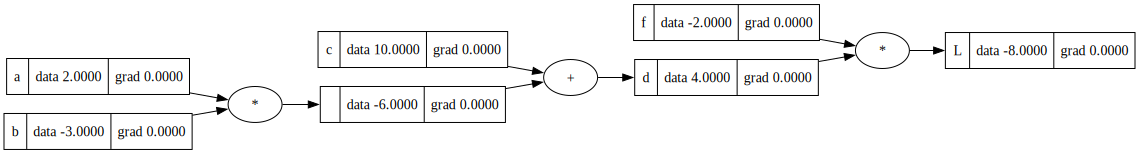

In [26]:
draw_dot(L)

Above, calculating L (i.e., the stand-in for the loss function) is the forward pass. We want to know the derivative of L with respect to each node that leads to L - i.e., how does L change when we tweak f, or d, etc.

We manually calculated the gradients as part of the lecture from around 30m to 60m or so - key thing is the use of what he called the 'local gradient' at the particular node and the gradient of the parent node, multiplying the two together because of the chain rule.

In [27]:
# we can numerically verify grad calc by tweaking the 'with respect to' value and manually calculating the gradient,
# which is the value of the 'gradient of' with a tiny bit added to it minus the value w/o it, normalized by the 
# tiny value - i.e., where h is the tiny bit:
# dL / da = (L2 - L1) / h

def quickie_validation():
    # he put this in a func so it wouldn't change the notebook/global vars

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (a * b) + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (a * b) + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

quickie_validation()

-3.9999999999995595


Create a simple network w/ weights and input values - still not exactly like a real NN, since we don't have many weights in vectors/matrices, etc. - but a bit more like that than the above. The Value constructor sets the gradient for each Value to zero as part of this creation.

In [58]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # set so the grad numbers come out nicely
# x1w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

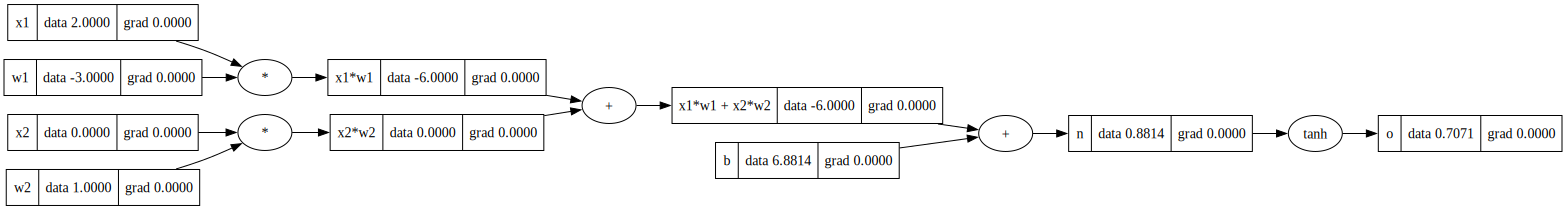

In [59]:
draw_dot(o)

Argh... I had a cell w/ notes showing how to manually backpropogate, and also how to call _backward starting from the end, and then I deleted it accidentally and got lost in the Jupyter undo/redo stack, and now it's gone. I'm not going to worry about it and just go on to the topological sort impl that figures out in what order to call _backward.

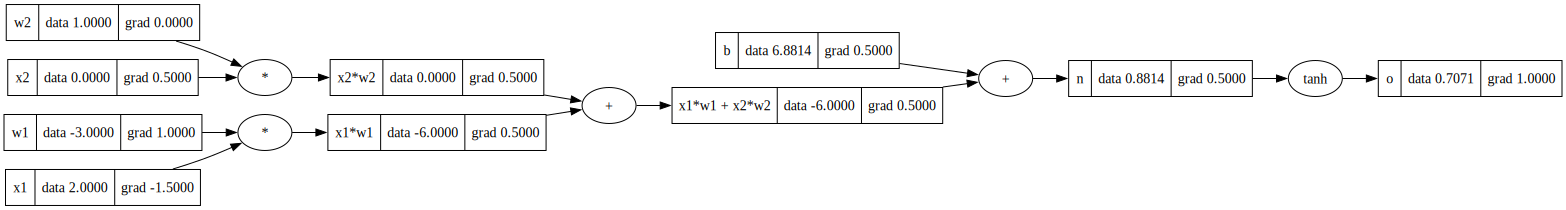

In [30]:
o.backward()
draw_dot(o)

Next few show how we correctly calc the gradients when we have multiple parents, because we accumulate (+=) each grad - 'deposit the gradients from each branch' - rather than the original and not correct overwrite.

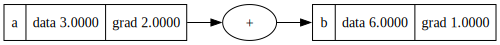

In [32]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

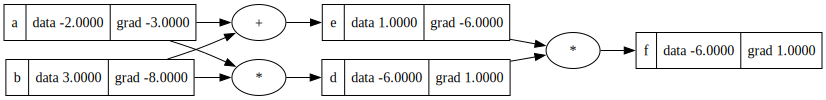

In [33]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

Originally we directly coded the derivative of tanh in the tanh _backward. Another way to represent the derivative is as an expression using exp, and now that we have implemented the components that we need to do this expression in Value (i.e., exp, subtraction, division) we can replace the use of tanh with the expression, and we should get the same gradients as we do above. 

In [60]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # set so the grad numbers come out nicely
# x1w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()

And, yep, the forward pass/value at the end are identical, and the gradients at the beginning are also identical, as shown below. (Scroll to the right to compare and see the many more nodes.)

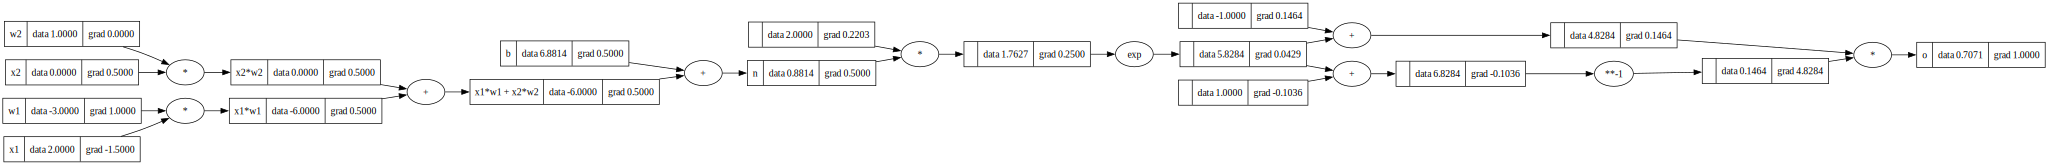

In [61]:
draw_dot(o)